## Oscillons

In [1]:
%matplotlib inline

In [2]:
import os,sys
sys.path.append('./bubbles_codes/')
from plotting import *
from bubble_tools import *
from experiment import *
%run './bubbles_codes/plotting.py'
from itertools import chain
import operator as op
import pywt


In [43]:
def get_bubble(exp_params, sim, crit_thresh, crit_rad):
    path2sim   = sim_location(*exp_params, sim)

    real, outcome = get_realisation(nLat, sim, phieq, path2sim)
    tdecay = max(0, np.shape(real)[1]-nLat//6)
    bubble, crit_rad = centre_bubble(real, tdecay, phieq, crit_thresh)

    nC, nT, nN = np.shape(bubble); print(nT, nN)
    bubble = bubble[0]

    tcen, xcen = find_nucleation_center(bubble, phieq, crit_thresh, crit_rad)
    #bubble = bubble[np.max(0,tcen-nN*2//3):tcen]
    #mn = np.mean(bubble)
    #bubble = bubble-mn
    #return bubble, mn
    return bubble, 0

def get_HT(array):  
    array = array - np.mean(array)
    w  = np.fft.fftfreq(len(array), d=1) * len(array)
    FD = np.fft.fft(array, axis=0)
    FD[w<=0.,:] = 0.
    FD[w>0.,:] *= 2.
    HD = np.fft.ifft(FD, axis=0)
    return np.abs(HD)

def get_osc_trajectory(array, extent):
    # find maximum value in array
    T, N = np.shape(array)
    flattened = chain.from_iterable(array)
    max_idx, max_val = max(enumerate(flattened), key=op.itemgetter(1))
    row = max_idx // N
    col = max_idx % N
#    print(array[row][col] == max_val, max_val, array[row][col], row, col)
#    ax[axis].plot(col, row, 'ro', ms=10)

    # use as starting point for oscillon trajectory
#    print(col, row)
    maxLine = []
    CCol = col
    for rr in range(row)[::-1]:
        if rr == row-1:
            col = CCol
        colmin = col - extent
        colmax = col + extent+1
        val = 0
        for cc in range(colmin, colmax):
            cc = cc%N
            if array[rr][cc] > val:
                val = array[rr][cc]
                col = cc
        maxLine.append(col)
    maxLine = maxLine[::-1]
    for rr in range(row, T):
        if rr == row:
            col = CCol
        colmin = col - extent
        colmax = col + extent+1
        val = 0
        for cc in range(colmin, colmax):
            cc = cc%N
            if array[rr][cc] > val:
                val = array[rr][cc]
                col = cc
        maxLine.append(col)
    return np.array(maxLine)

# average oscillon trajectories
def tolerant_mean(arrs):
    lens = np.array([len(i) for i in arrs])
  #  print(lens.tolist())
    arr  = np.zeros((len(lens), np.max(lens)))
    for ri, osc in enumerate(arrs):
        arr[ri, :len(osc)] = osc
    arr[arr == 0] = np.nan
    return np.nanmean(arr, axis=0), np.nanstd(arr, axis=0)

def tolerant_mean2d(arrs):
    lens = np.array([np.shape(i) for i in arrs])
    lens1, lens2 = lens[:,0], lens[:,1]

    arr  = np.zeros((len(arrs), np.max(lens1), np.max(lens2)))
    for ri, osc in enumerate(arrs):
        n1, n2 = np.shape(osc)
        arr[ri, :n1, :n2] = osc
    arr[arr == 0.] = np.nan
    return np.nanmean(arr, axis=0), np.nanstd(arr, axis=0)


In [50]:
simLists = []
tmp = 0
phi0, lamb, sigmafld, minSim, maxSim, right_Vmax, normal = get_model(tmp)
exp_params = np.asarray([nLat, lamb, phi0, temp])
for sim in range(minSim, maxSim):
    path2sim = sim_location(*exp_params, sim)
    if os.path.exists(path2sim):
        simLists.append(sim)
simLists = np.array(simLists)

In [51]:
simLists

array([  0,   1,   2,   3,   4, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 200, 201, 202, 203, 300, 301, 302, 303, 400, 401, 500, 600,
       601, 700, 800, 801, 802, 900, 901])

In [52]:
crit_rad = 100
crit_thresh = right_Vmax.x + 3.*sigmafld; print(crit_thresh)


5.664777490695018


2841 2048
2841 2048


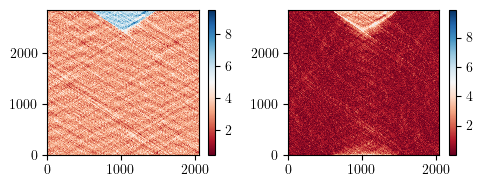

In [58]:
sim = simLists[9]

bubble, _ = get_bubble(exp_params, sim, crit_thresh, crit_rad)
nT, nN = np.shape(bubble); print(nT, nN)

fig, ax = plt.subplots(1, 2, figsize=(5,2))
im1 = ax[0].imshow(bubble, aspect='auto', cmap='RdBu', interpolation='none', origin='lower')

ws = np.fft.fftfreq(nT, d=1) * nT
dirft = np.fft.fft(bubble, axis=0)
dirft[ws<=0,:]=0.
dirft[ws>0,:]*=2.
hilbft = np.fft.ifft(dirft, axis=0)

im2 = ax[1].imshow(np.abs(hilbft), aspect='auto', cmap='RdBu', interpolation='none', origin='lower')
clb = plt.colorbar(im1, ax = ax[0])
clb = plt.colorbar(im2, ax = ax[1])
plt.tight_layout()
plt.show()

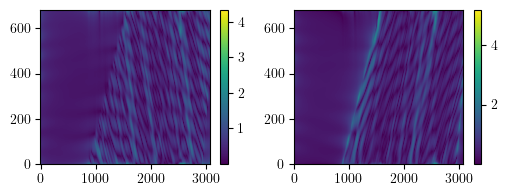

In [8]:
tw = np.fft.fftfreq(nT, d=1) * nT
xw = np.fft.fftfreq(nN, d=1) * nN
tFD = np.fft.fft(bubble, axis=0)
xFD = np.fft.fft(bubble, axis=1)
xFD[:,xw<0] = 0.
xFD[:,xw>0]*= 2.
tFD[tw<0,:] = 0.
tFD[tw>0,:]*= 2.
tHD = np.fft.ifft(tFD, axis=0)
xHD = np.fft.ifft(xFD, axis=1)

lFD = np.fft.fft(tHD, axis=1)
rFD = np.fft.fft(xHD, axis=0)
lFD[:,xw<0] = 0.
lFD[:,xw>0]*= 2.
rFD[tw>0,:] = 0.
rFD[tw<0,:]*= 2.
lHD = np.fft.ifft(lFD, axis=1)
rHD = np.fft.ifft(rFD, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(6,2))
im1 = ax[0].imshow(np.abs(lHD), aspect='auto', interpolation='none', origin='lower')
im2 = ax[1].imshow(np.abs(rHD), aspect='auto', interpolation='none', origin='lower')
plt.colorbar(im1, ax=ax[0])
plt.colorbar(im2, ax=ax[1])
plt.show()

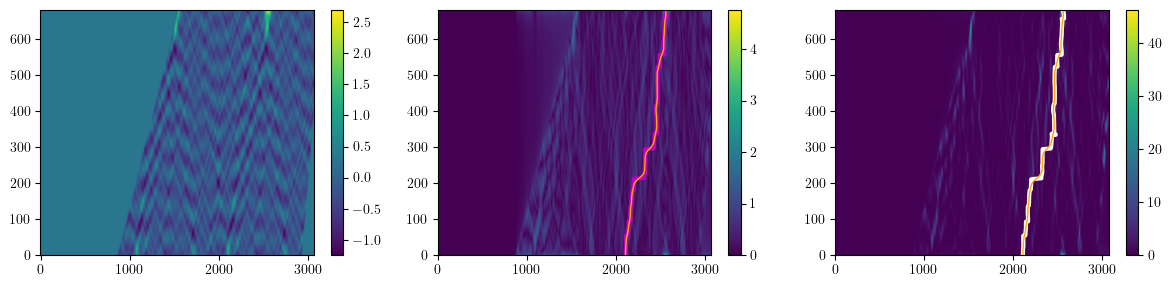

In [9]:
nT, nN = np.shape(bubble)
aHD = get_HT(bubble)

amp = 3
t = aHD**amp / np.sum(aHD**amp, axis=1)[:,None] 
SB = t*np.arange(nN)[None,:]
xt = np.sum(SB, axis=1)

fig, ax = plt.subplots(1, 3, figsize=(12,3))
im1 = ax[0].imshow(bubble, aspect='auto', interpolation='none', origin='lower') #original
im2 = ax[1].imshow(aHD,     aspect='auto', interpolation='none', origin='lower') #hilbert transform amplitude
im3 = ax[2].imshow(SB,      aspect='auto', interpolation='none', origin='lower') #power spectrum method

l1 = get_osc_trajectory(aHD, extent=50)
l2 = gaussian_filter1d(l1, sigma=10, mode='nearest')

l3 = get_osc_trajectory(SB, extent=50)
l4 = gaussian_filter1d(l3, sigma=10, mode='nearest')

ylist = np.arange(nT)
ax[1].plot(l1, ylist, color='m', linewidth=3)
ax[1].plot(l2, ylist, color='orange', linewidth=1)

ax[2].plot(l3, ylist, color='white', linewidth=3)
ax[2].plot(l4, ylist, color='orange', linewidth=1)

plt.colorbar(im1, ax = ax[0])
plt.colorbar(im2, ax = ax[1])
plt.colorbar(im3, ax = ax[2])
plt.tight_layout()
plt.show()

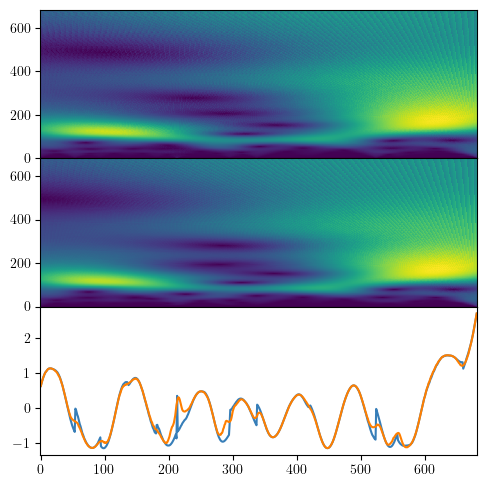

In [10]:
# wavelet transform on oscillon maplitude
C,B    = 1,1 # center, bandwidth # C = freq to investigate, B = bandwidth
wavelt = "cmor%f_%f"%(C,B)
dt     = 1
scales = np.arange(1, nT+1)

# construct field value of oscillon over trajectory above
oscillonAmp = bubble[np.arange(nT), l1] 
CC, f = pywt.cwt(oscillonAmp, scales, wavelt, sampling_period=dt)

smoscillonAmp = bubble[np.arange(nT), l2]
BB, f = pywt.cwt(smoscillonAmp, scales, wavelt, sampling_period=dt)

fig, ax = plt.subplots(3, 1, figsize=(5, 5), gridspec_kw=dict(hspace=0), sharex=True)
ax[0].imshow(np.abs(CC), aspect='auto', interpolation='none', origin='lower')
ax[1].imshow(np.abs(BB), aspect='auto', interpolation='none', origin='lower')
ax[2].plot(oscillonAmp)
ax[2].plot(smoscillonAmp)
plt.tight_layout()
plt.show()

### FT of Oscillon Signal

In [11]:
if False:
    saveTFreqs, saveTPS, saveXFreqs, saveXPS = [], [], [], []
    for si, sim in enumerate(simLists):
        bubble, _ = get_bubble(exp_params, sim, crit_thresh, crit_rad)
        nT, nN = np.shape(bubble)

        try:
            aHT = get_HT(bubble)
        except:
            continue
        oscillonAmp = get_osc_trajectory(aHT, extent=50)
        oscillonAmp = bubble[np.arange(nT), oscillonAmp]
        oscillonAmp = np.fft.fft(oscillonAmp)
        freqs       = np.fft.fftfreq(nT, d=1) * nT # get frequencies; d = x space units

        valMax = 1e7
        PS     = np.conj(oscillonAmp)*oscillonAmp
        coords = np.argwhere(PS>valMax) # separate freqs where there is large field response

        saveTFreqs.append(freqs[coords]*nT)
        saveTPS.append(PS[coords].real)

        for slice in bubble:
            fftbubble = np.fft.fft(slice)
            freqs     = np.fft.fftfreq(nN, d=1) * nN

            PS     = np.conj(fftbubble)*fftbubble
            coords = np.argwhere(PS>valMax)

            saveXFreqs.append(freqs[coords]*nN)
            saveXPS.append(PS[coords].real)

In [12]:
if False:
    # flat list of all frequencies where response is strong
    allTFreqs = np.asarray([np.round(item,10) for sublist in saveTFreqs for item in sublist]).flatten()
    allTPS    = np.asarray([item for sublist in saveTPS for item in sublist]).flatten()

    # cut duplicates
    set_freqs   = np.sort(list(dict.fromkeys(np.abs(allTFreqs))))
    set_totamps = np.zeros(len(set_freqs))

    # and again in x
    allXFreqs = np.asarray([np.round(item,10) for sublist in saveXFreqs for item in sublist]).flatten()
    allXPS    = np.asarray([item for sublist in saveXPS for item in sublist]).flatten()

    # cut duplicates
    set_Xfreqs   = np.sort(list(dict.fromkeys(np.abs(allXFreqs))))
    set_Xtotamps = np.zeros(len(set_Xfreqs))

    # add field responses to get relative importance of each mode
    for fi, frq in enumerate(set_freqs):
        inds = np.argwhere(np.abs(allTFreqs)==frq).flatten()
        set_totamps[fi] = np.sum(allTPS[inds])

    # and in X
    for fi, frq in enumerate(set_Xfreqs):
        inds = np.argwhere(np.abs(allXFreqs)==frq).flatten()
        set_Xtotamps[fi] = np.sum(allXPS[inds])

    # plot frequency vs response; plot mass from frequency and compare with free mass
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].plot(set_freqs, set_totamps)
    ax[0].set_xlabel(r'$\omega$')
    ax[1].plot(set_Xfreqs, set_Xtotamps)
    ax[1].set_xlabel(r'$k$')

    for aa in ax:
        aa.set_yscale('log')
    plt.tight_layout()
    plt.show()
    
    masses = set_freqs[:,None]**2. - set_Xfreqs[None,:]**2.
    masses = masses.flatten()
    masses = masses[masses>0.]
    masses = [i for i in masses if not np.isnan(i)]

    fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))
    ah = plt.hist(masses, bins=20, density=True)


In [13]:
def omega(ksq, a, m):
    return a*ksq + m**2

if False:
    fig, ax = plt.subplots(1, 2, figsize=(6, 2))
    for si, sim in enumerate(simLists):
        bubble, _ = get_bubble(exp_params, sim, crit_thresh, crit_rad)
        nT, nN = np.shape(bubble)

        bubblePS = np.fft.fft2(bubble)[:nT//6,:nN//6]
        bubblePS = np.conj(bubblePS)*bubblePS

        maxVal = 5e6
        bubble_coords = np.argwhere(bubblePS>maxVal)

        kkk, ooo = bubble_coords[:,1]**2., bubble_coords[:,0]**2.
        popt2, pcov2 = sco.curve_fit(omega, kkk, ooo)

        if True:
            if si%10!=4: continue
            ax[0].imshow(bubblePS.real>maxVal, aspect='auto', interpolation='none', origin='lower')

            ax[1].plot(kkk, omega(kkk, *popt2), '-')#, label='fit: a=%5.3f, m=%5.3f' % tuple(popt2))
            ax[1].plot(kkk, ooo, 'go', ms=1)
    for aa in ax:
        aa.set_xlabel(r'$k^2$')
        aa.set_ylabel(r'$\omega_k^2$')
    plt.show()

### Average Oscillon Signal

2243 3072
SIMULATION 111


/Users/dalilapirvu/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


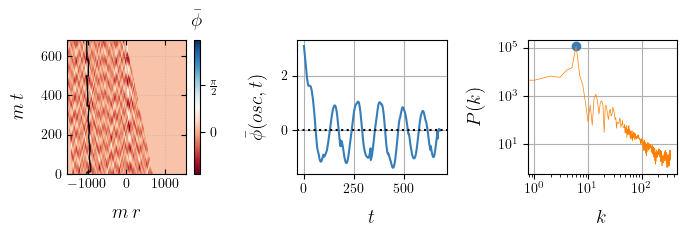

2469 3072
SIMULATION 928


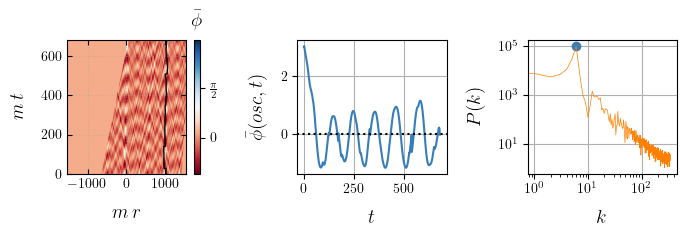

3254 3072
SIMULATION 1971


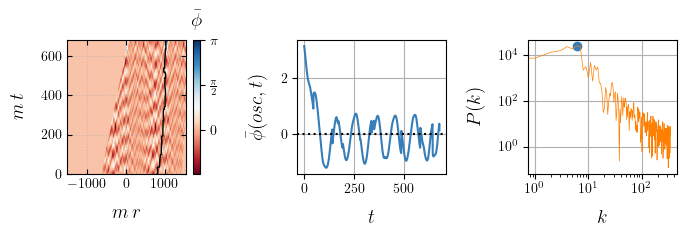

In [14]:
#oscillonWT = []
for si, sim in enumerate(simLists):
    if si%10!=1: continue
    
    bubble, _ = get_bubble(exp_params, sim, crit_thresh, crit_rad)
    nT, nN = np.shape(bubble)
    try: aHD = get_HT(bubble)
    except: continue

    maxln1 = get_osc_trajectory(aHD, extent=50)
    avOscillon = bubble[np.arange(nT), maxln1][::-1]
    maxln1-= nN//2

#    # wavelet transform on oscillon maplitude
#    C,B     = 1,1 # center, bandwidth # C = freq to investigate, B = bandwidth
#    wavelet = "cmor%f_%f"%(C,B)
#    dt      = 1
#    scales  = np.arange(1,nT)
#    CC, f   = pywt.cwt(avOscillon, scales, wavelet, sampling_period=dt)
#    oscillonWT.append(CC)

    print('SIMULATION', sim)
    fig, ax = plt.subplots(1, 3, figsize=(7, 2.5))
        
    exts = np.array([-nN//2,nN//2,0,nT])
    im1 = ax[0].imshow(bubble, extent=exts, aspect='auto', interpolation='none', origin='lower', cmap='RdBu') #original
    
    ylist = np.arange(nT)
    ax[0].plot(maxln1, ylist, ls='-', color='k', linewidth=1)

    ax[0].set(xlabel=r'$m \, r$')
    ax[0].set(ylabel=r'$m \, t$')
    ax[0].tick_params(direction='in', which='both', top=True, right=True)
    ax[0].grid(ls=':', color='darkgray', alpha=0.5)

    cbar = fig.colorbar(im1, ax=ax[0], ticks=mticker.MultipleLocator(np.pi/2), \
                        format=mticker.FuncFormatter(multiple_formatter()))
    cbar.ax.set_title(r'$\bar{\phi}$')

    ax[1].plot(np.arange(nT), avOscillon)
    ax[1].set_xlabel(r'$t$')
    ax[1].set_ylabel(r'$\bar{\phi}(osc,t)$')
    ax[1].axhline(0, ls=':', color='k')

    y_fft = np.fft.rfft(avOscillon)
    freqs = np.fft.rfftfreq(nT, d=1) * nT
    psyfd = np.conj(y_fft)*y_fft
    ind   = np.argmax(psyfd)

    ax[2].loglog(freqs[ind], psyfd[ind], 'o')
    ax[2].loglog(freqs, psyfd, linewidth=0.5)
    ax[2].set_xlabel(r'$k$')
    ax[2].set_ylabel(r'$P(k)$')

    for aa in ax: aa.grid(True)

    plt.tight_layout()
    plt.show()

In [15]:
if False:
    fig, ax = plt.subplots(1, 2, figsize = (8, 2.5))
    oscillonAmp, freqs_vec, freqsAmp, allfreqs_vec = [], [], [], []
    for si, sim in enumerate(simLists):

        bubble, _ = get_bubble(exp_params, sim, crit_thresh, crit_rad)
        nT, nN = np.shape(bubble)

        try:
            aHT = get_HT(bubble)
        except:
            continue
        maxln1 = get_osc_trajectory(aHT, extent=50)
        avOscillon = bubble[np.arange(nT), maxln1][::-1]
        maxln1-= nN//2

        oscillonAmp.append(avOscillon)

        ax[0].plot(np.sqrt(m2(lamb))*dx*np.arange(nT), avOscillon, linewidth=0.05)

        y_fft = np.fft.rfft(avOscillon)
        freqs = np.fft.rfftfreq(nT, d=1) * nT
        psyfd = (np.conj(y_fft)*y_fft).real
        ind   = np.argmax(psyfd)

        freqs_vec.append(freqs[ind])
        allfreqs_vec.append(freqs)

        try:
            freqsTot = np.fft.rfftfreq(len(avOS), d=1) * len(avOS)
            freqsAmp.append(psyfd[freqs==freqsTot])
        except:
            continue

        ax[1].loglog(freqs[ind], psyfd[ind], 'o')
        ax[1].loglog(freqs, psyfd, linewidth=0.1)

    avOS, error1 = tolerant_mean(oscillonAmp)
    ax[0].plot(np.sqrt(m2(lamb))*dx*np.arange(len(avOS)), avOS, linewidth=1, color='k')

    #avSP, error1 = tolerant_mean(freqsAmp)
    #ax[1].plot(freqsTot, avSP, linewidth=1, color='k')

    ax[0].set_xlabel(r'$t$')
    ax[0].set_ylabel(r'$\bar{\phi}^{\rm osc}(t)$')
    ax[0].axhline(0, ls=':', color='k')
    ax[0].set_xlim(0, 18)#np.sqrt(m2(lamb))*dx*len(avOS))

    ax[1].set_xlabel(r'$k$')
    ax[1].set_ylabel(r'$P(k)$')

    for aa in ax:
        aa.grid(True)
    plt.tight_layout()
    plt.savefig('./plots/av_oscillon_and_freq.pdf', dpi=500, rasterize=True)
    plt.show()

3665 3072
2243 3072
2914 3072
4193 3072
4302 3072
1744 3072
3083 3072
1469 3072
4386 3072
3440 3072
1592 3072
2469 3072
5293 3072
4348 3072
2447 3072
1430 3072
3051 3072
3836 3072
2109 3072
1630 3072
3543 3072
3254 3072
2304 3072
3393 3072
1217 3072


/var/folders/y9/3fb45z893_907tsjq09bjhbh0000gn/T/ipykernel_19310/3388647985.py:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('./plots/av_oscillon.pdf', dpi=500, rasterize=True)


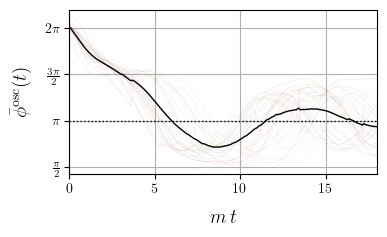

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (4, 2.5))
means, count, oscillonAmp = 0., 0., []
for si, sim in enumerate(simLists):
    bubble, mn = get_bubble(exp_params, sim, crit_thresh, crit_rad)
    nT, nN = np.shape(bubble)

    try: aHT = get_HT(bubble)
    except: continue

    means += mn
    count += 1

    maxln1 = get_osc_trajectory(aHT, extent=50)
    avOscillon = bubble[np.arange(nT), maxln1][::-1]
    oscillonAmp.append(avOscillon)

    ax.plot(np.sqrt(m2(lamb))*dx*np.arange(len(avOscillon)), avOscillon + mn, linewidth=0.1, alpha=0.5)

means = means/count
avOS, error1 = tolerant_mean(oscillonAmp)
ax.plot(np.sqrt(m2(lamb))*dx*np.arange(len(avOS)), avOS + means, linewidth=1, color='k')

ax.yaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.yaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
ax.axhline(np.pi, ls=':', color='k', linewidth=1)

ax.set_xlabel(r'$m \, t$')
ax.set_ylabel(r'$\bar{\phi}^{\rm osc}(t)$')
ax.set_xlim(0, 18)#np.sqrt(m2(lamb))*dx*len(avOS))
ax.grid(True)
plt.tight_layout()
plt.savefig('./plots/av_oscillon.pdf', dpi=500, rasterize=True)
plt.show()

./data/instanton_x1024_phi01.3963_lambda1.5000_fields.dat
(682, 342)
/Users/dalilapirvu/Documents/data_scalar/precursor_x1024_phi01.3963_lambda1.5000_T0.0900_sim0_fields.dat
(682, 342)


/var/folders/y9/3fb45z893_907tsjq09bjhbh0000gn/T/ipykernel_19310/1859723804.py:49: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('./plots/standard_oscillons.pdf', dpi=500, rasterize=True)


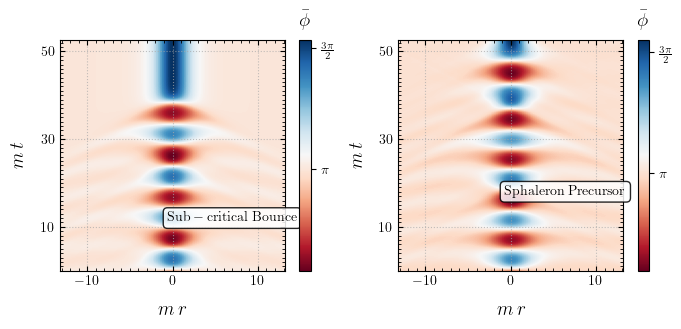

In [22]:
if True:
    titls = [r'$\rm Sub-critical \; Bounce$', r'$\rm Sphaleron \; Precursor$']

    print(instanton_sim_file(*exp_params[:-1]))
    instanton_sim = extract_data(nLat, instanton_sim_file(*exp_params[:-1]))
    instanton_sim = instanton_sim[0, :nLat*2//3, nLat//3:2*nLat//3+1][::-1]
    nT, nN = np.shape(instanton_sim)
    print(np.shape(instanton_sim))

    print(precursor_sim_file(*exp_params))
    precursor_sim = extract_data(nLat, precursor_sim_file(*exp_params))
    precursor_sim = precursor_sim[0, :nT, nLat//3:2*nLat//3+1][::-1]
    print(np.shape(precursor_sim))

    exts = np.array([-nN//2,nN//2,0,nT])*dx*np.sqrt(m2(lamb))

    fig, ax = plt.subplots(1, 2, figsize = (8,3))
    im0 = ax[0].imshow(instanton_sim, aspect='auto', interpolation='none', extent=exts, origin='lower', cmap='RdBu')
    clb0 = plt.colorbar(im0, ax = ax[0], ticks = mticker.MultipleLocator(np.pi/2), format = mticker.FuncFormatter(multiple_formatter()))
    clb0.ax.set_title(r'$\bar{\phi}$')

    im1 = ax[1].imshow(precursor_sim, aspect='auto', interpolation='none', extent=exts, origin='lower', cmap='RdBu')
    clb1 = plt.colorbar(im1, ax = ax[1], ticks = mticker.MultipleLocator(np.pi/2), format = mticker.FuncFormatter(multiple_formatter()))
    clb1.ax.set_title(r'$\bar{\phi}$')

    for ai, aa in enumerate(ax):
        aa.text([7.,6.4][ai], [12.,18.][ai], titls[ai], ha='center', va='center', \
                bbox={'boxstyle':'round','facecolor':'white','alpha':0.85,'edgecolor':'k','pad':0.3}, fontsize=10)

        aa.grid(ls=':', color='darkgray', alpha=0.7)
        aa.xaxis.set_minor_locator(MultipleLocator(1))
        aa.yaxis.set_minor_locator(MultipleLocator(1))
        aa.set_xlabel(r'$m \, r$')
        aa.set_ylabel(r'$m \, t$')
        aa.yaxis.set_ticks_position('both')
        aa.xaxis.set_ticks_position('both')
        aa.tick_params(which='both', axis="y", direction="in")
        aa.tick_params(which='both', axis="x", direction="in")
        # a = aa.get_xticks().tolist()[1:-1:]
       # a = [round(al,2) for al in a]
       # aa.set_xticks(a)
        # aa.set_xticklabels(a)
        a = aa.get_yticks().tolist()[1:-1:2]
        a = [round(al,2) for al in a]
        aa.set_yticks(a)
        a = [r'${:.0f}$'.format(al) for al in a]
        aa.set_yticklabels(a)

    plt.savefig('./plots/standard_oscillons.pdf', dpi=500, rasterize=True)
    plt.show()


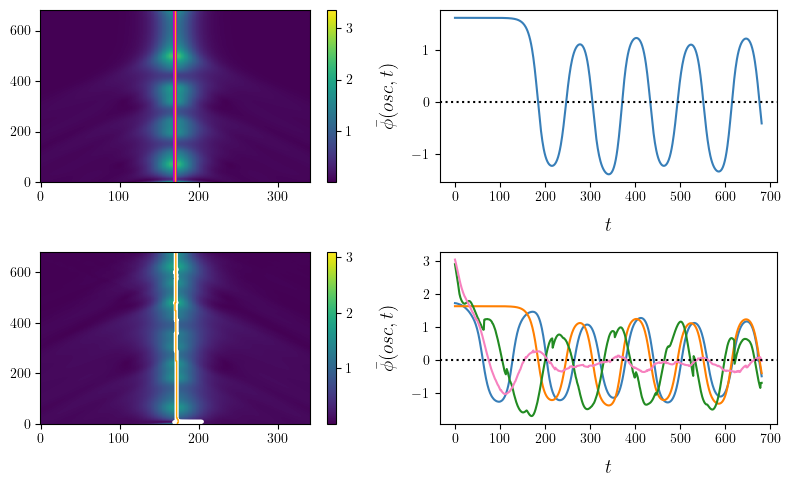

In [18]:
instanton_sim = instanton_sim - np.mean(instanton_sim)
nT, nN = np.shape(instanton_sim)
aHD_inst = get_HT(instanton_sim)

precursor_sim = precursor_sim - np.mean(precursor_sim)
aHD_prec = get_HT(precursor_sim)

fig, ax = plt.subplots(2, 2, figsize=(8,5))
im1 = ax[0,0].imshow(aHD_inst, aspect='auto', interpolation='none', origin='lower')
im2 = ax[1,0].imshow(aHD_prec, aspect='auto', interpolation='none', origin='lower')

l1 = get_osc_trajectory(aHD_inst, extent=50)
l2 = gaussian_filter1d(l1, sigma=10, mode='nearest')

l3 = get_osc_trajectory(aHD_prec, extent=50)
l4 = gaussian_filter1d(l3, sigma=10, mode='nearest')

ylist = np.arange(nT)
ax[0,0].plot(l1, ylist, color='m', linewidth=3)
ax[0,0].plot(l2, ylist, color='orange', linewidth=1)

ax[1,0].plot(l3, ylist, color='white', linewidth=3)
ax[1,0].plot(l4, ylist, color='orange', linewidth=1)

avOscillon_inst = instanton_sim[np.arange(nT), l1][::-1]
ax[0,1].plot(np.arange(nT), avOscillon_inst)
avOscillon_prec = precursor_sim[np.arange(nT), l3][::-1]
ax[1,1].plot(np.arange(nT), avOscillon_prec)
ax[1,1].plot(np.arange(nT), avOscillon_inst)
ax[1,1].plot(np.arange(len(avOscillon)), avOscillon)
ax[1,1].plot(np.arange(len(avOS)), avOS)

ax[0,1].set_xlabel(r'$t$')
ax[1,1].set_xlabel(r'$t$')
ax[0,1].set_ylabel(r'$\bar{\phi}(osc,t)$')
ax[1,1].set_ylabel(r'$\bar{\phi}(osc,t)$')
ax[0,1].axhline(0, ls=':', color='k')
ax[1,1].axhline(0, ls=':', color='k')

plt.colorbar(im1, ax = ax[0,0])
plt.colorbar(im2, ax = ax[1,0])
plt.tight_layout()
plt.show()

3665 3072
2243 3072
2914 3072
4193 3072
4302 3072
1744 3072
3083 3072
1469 3072
4386 3072
3440 3072
1592 3072
2469 3072
5293 3072
4348 3072
2447 3072
1430 3072
3051 3072
3836 3072
2109 3072
1630 3072
3543 3072
3254 3072
2304 3072
3393 3072
1217 3072


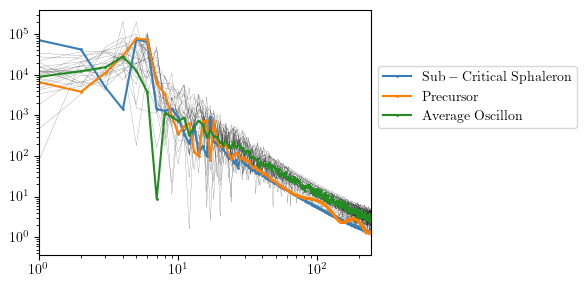

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

freqs_vec = []
if True:
    for si, sim in enumerate(simLists):
        bubble, _ = get_bubble(exp_params, sim, crit_thresh, crit_rad)
        nT = len(bubble)
        try: aHT = get_HT(bubble)
        except: continue

        maxln1 = get_osc_trajectory(aHT, extent=50)
        maxln1 = gaussian_filter1d(maxln1, sigma=10, mode='nearest')
        avOscillon = bubble[np.arange(nT), maxln1][::-1]
        maxln1-= nN//2

        y_fft = np.fft.rfft(avOscillon)
        freqs = np.fft.rfftfreq(nT, d=1) * nT
        psyfd = (np.conj(y_fft)*y_fft).real
        ind   = np.argmax(psyfd)
        freqs_vec.append(freqs[ind])

        #plt.loglog(freqs[ind], psyfd[ind], 'o', ms=3, color='k')
        plt.loglog(freqs[1:], psyfd[1:], linewidth=0.1, color='k')

y_fft  = np.fft.rfft(avOscillon_inst)
nT     = len(avOscillon_inst)
freqs1 = np.fft.rfftfreq(nT, d=1.) * nT
psyfd  = (np.conj(y_fft)*y_fft).real
ind    = np.argmax(psyfd)
freqmax1 = freqs1[ind]
plt.loglog(freqs1, psyfd, ls='-', marker='o', ms=1, label=r'$\rm Sub-Critical \; Sphaleron$')

y_fft  = np.fft.rfft(avOscillon_prec)
nT     = len(avOscillon_prec)
freqs2 = np.fft.rfftfreq(nT, d=1.) * nT
psyfd  = (np.conj(y_fft)*y_fft).real
ind    = np.argmax(psyfd)
freqmax2 = freqs2[ind]
plt.loglog(freqs2, psyfd, ls='-', marker='o', ms=1, label=r'$\rm Precursor$')

y_fft  = np.fft.rfft(avOS)
nT     = len(avOS)
freqs3 = np.fft.rfftfreq(nT, d=1.) * nT
psyfd  = (np.conj(y_fft)*y_fft).real
ind    = np.argmax(psyfd)
freqmax3 = freqs3[ind]
plt.loglog(freqs3, psyfd, ls='-', marker='o', ms=1, label=r'$\rm Average \; Oscillon$')

plt.xlim((freqs2[1], freqs2[-100]))
leg = ax.legend(ncol=1, loc='best', fontsize=10, bbox_to_anchor=(1, 0.8))
plt.tight_layout()
#plt.savefig('./plots/all_freqs.pdf', dpi=500, rasterize=True)
plt.show()

/var/folders/y9/3fb45z893_907tsjq09bjhbh0000gn/T/ipykernel_19310/2621535901.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('./plots/characteristic_osc_frequency.pdf', dpi=500, rasterize=True)


[]

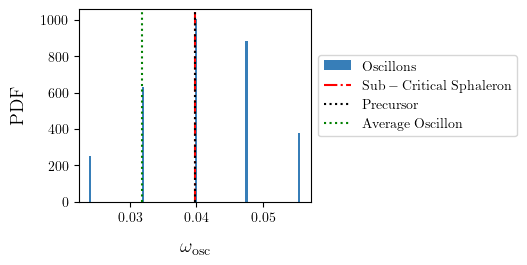

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))

ah = plt.hist(dk * np.array(freqs_vec), bins=100, density=True, label=r'$\rm Oscillons$')
plt.axvline(dk * freqmax1, color='r', ls='-.', label=r'$\rm Sub-Critical \; Sphaleron$')
plt.axvline(dk * freqmax2, color='k', ls=':', label=r'$\rm Precursor$')
plt.axvline(dk * freqmax3, color='g', ls=':', label=r'$\rm Average \; Oscillon$')

ax.set_ylabel(r'$\rm PDF$')
ax.set_xlabel(r'$\omega_{\rm osc}$')
leg = ax.legend(ncol=1, loc='best', fontsize=10, bbox_to_anchor=(1, 0.8))

plt.savefig('./plots/characteristic_osc_frequency.pdf', dpi=500, rasterize=True)
plt.plot()
